In [3]:
import joblib
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path

path = Path(os.getcwd()).resolve().parent.parent
if path not in sys.path:
    sys.path.append(str(path))

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from src.utils.data_loader import load_preprocessed_data
from src.data.save_results import save_model_scores, save_model_predictions

target_variables = [
    "temperature_2m_max",
    "apparent_temperature_min",
    "relative_humidity_2m_max",
    "wind_speed_10m_max",
    "winddirection_10m_dominant",
    "rain_sum",
    "shortwave_radiation_sum"
]

for target_variable in target_variables:
    data = load_preprocessed_data(target_variable)

    DATA = data["DATA"]
    TRAINED_DATA = data["TRAINED_DATA"]
    METHOD = data["METHOD"]

    X_train_selected = data["X_train_selected"]
    X_test_selected = data["X_test_selected"]
    y_train = data["y_train"]
    y_test = data["y_test"]
    preprocessor = data["preprocessor"]

    tscv = TimeSeriesSplit(n_splits=5)
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", RandomForestRegressor(n_estimators=100, random_state=42))
    ])

    cv_scores = cross_val_score(pipeline, X_train_selected, y_train, 
                                cv=tscv, scoring='neg_root_mean_squared_error')

    # Huấn luyện mô hình
    pipeline.fit(X_train_selected, y_train)

    # Dự đoán và đánh giá
    y_pred_rfr = pipeline.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred_rfr)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
    r2_rfr = r2_score(y_test, y_pred_rfr)

    print(f"[RESULT] Random Forest Regressor - {target_variable}")
    print(f"[CV RMSE]: {-np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")
    print(f"[MAE]: {mae:.2f}")
    print(f"[RMSE]: {rmse:.2f}")
    print(f"[R2 Score]: {r2_rfr:.2f}")
    
    PATH = DATA / "scores&predictions" / METHOD / target_variable
    save_model_scores("RandomForestRegressor(RFR)", mae, rmse, r2_rfr, -np.mean(cv_scores), np.std(cv_scores), PATH)
    save_model_predictions("RandomForestRegressor(RFR)", y_test, y_pred_rfr, PATH)

[RESULT] Random Forest Regressor - temperature_2m_max
[CV RMSE]: 0.39 ± 0.04
[MAE]: 0.24
[RMSE]: 0.34
[R2 Score]: 1.00
[RESULT] Random Forest Regressor - apparent_temperature_min
[CV RMSE]: 1.37 ± 0.10
[MAE]: 0.99
[RMSE]: 1.32
[R2 Score]: 0.97
[RESULT] Random Forest Regressor - relative_humidity_2m_max
[CV RMSE]: 2.32 ± 0.07
[MAE]: 1.53
[RMSE]: 2.13
[R2 Score]: 0.92
[RESULT] Random Forest Regressor - wind_speed_10m_max
[CV RMSE]: 1.24 ± 0.06
[MAE]: 1.02
[RMSE]: 1.35
[R2 Score]: 0.91
[RESULT] Random Forest Regressor - winddirection_10m_dominant
[CV RMSE]: 91.03 ± 3.43
[MAE]: 61.17
[RMSE]: 88.72
[R2 Score]: 0.15
[RESULT] Random Forest Regressor - rain_sum
[CV RMSE]: 6.01 ± 0.92
[MAE]: 2.88
[RMSE]: 6.98
[R2 Score]: 0.63
[RESULT] Random Forest Regressor - shortwave_radiation_sum
[CV RMSE]: 1.17 ± 0.01
[MAE]: 0.89
[RMSE]: 1.14
[R2 Score]: 0.97


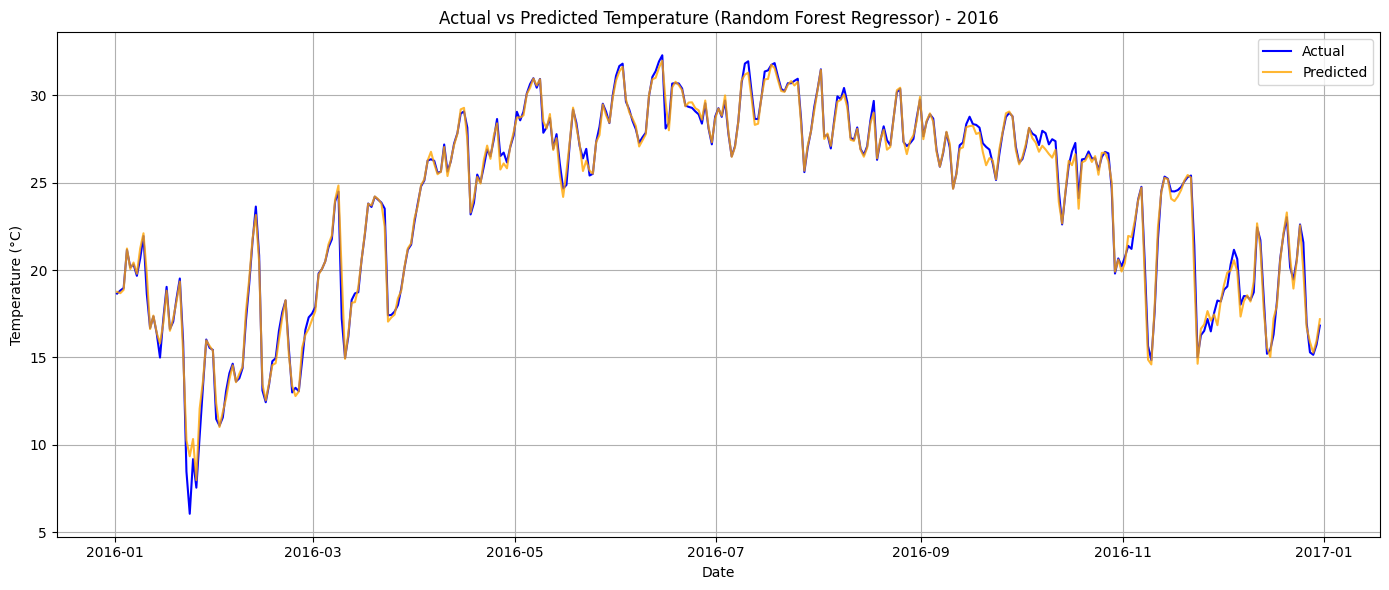

In [ ]:
import matplotlib.pyplot as plt

test_df = pd.read_csv(f"{TRAINED_DATA}/{METHOD}/test_df.csv", parse_dates=["date"])
# Thêm cột giá trị thực tế và dự đoán
test_df["actual"] = y_test.values
test_df["predicted"] = y_pred_rfr

# Lọc khoảng thời gian từ 01/01/2016 đến 31/12/2016
mask = (test_df["date"] >= "2016-01-01") & (test_df["date"] <= "2016-12-31")
subset_df = test_df[mask]

# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(subset_df["date"], subset_df["actual"], label="Actual", color="blue")
plt.plot(subset_df["date"], subset_df["predicted"], label="Predicted", color="orange", alpha=0.8)
plt.title("Actual vs Predicted Temperature (Random Forest Regressor) - 2016")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [11]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent.parent))
from src.data.save_results import save_model_scores, save_model_predictions

PATH = DATA / "scores&predictions" / METHOD
save_model_scores("RandomForestRegressor(RFR)", mae, rmse, r2_rfr, -np.mean(cv_scores), np.std(cv_scores), PATH)
save_model_predictions("RandomForestRegressor(RFR)", y_test, y_pred_rfr, PATH)
